In [58]:
import librosa 
from librosa import display
import pylab as plt
import os
import pandas as pd
import glob
import numpy as np
from numpy import savetxt
from numpy import asarray
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [59]:
path ='/Users/xx/Desktop/5452 pro/RAVDESS'
emotion = []
emotion_code =[]
gender = []
actor = []
file_path = []
for subdir,dirs,files in os.walk(path):
    for file in files:
        part = file.split('.')[0].split('-')
        emotion.append(int(part[2]))
        emotion_code.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        # if bg%2 == 0:
        #    bg = "female"
        #else:
        #    bg = "male"
        gender.append(bg)
        file_path.append('/Users/xx/Desktop/5452 pro/RAVDESS/' + file)
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),pd.DataFrame(emotion_code),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion_code','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [60]:
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    df.loc[counter] = [db_spec]
    counter=counter+1
    
audio_df['mel_spectrogram']= df['mel_spectrogram']
print(audio_df.head())
print(audio_df.shape)

   gender  emotion_code   emotion  actor  \
0       2             6      fear      2   
1      16             5     angry     16   
2      16             3     happy     16   
3      14             8  surprise     14   
4       2             3     happy      2   

                                                path  \
0  /Users/xx/Desktop/5452 pro/RAVDESS/03-01-06-01...   
1  /Users/xx/Desktop/5452 pro/RAVDESS/03-01-05-01...   
2  /Users/xx/Desktop/5452 pro/RAVDESS/03-02-03-02...   
3  /Users/xx/Desktop/5452 pro/RAVDESS/03-01-08-01...   
4  /Users/xx/Desktop/5452 pro/RAVDESS/03-02-03-02...   

                                     mel_spectrogram  
0  [[-66.32325, -66.32325, -66.32325, -66.32325, ...  
1  [[-62.853226, -62.853226, -62.853226, -62.8532...  
2  [[-63.636585, -63.636585, -63.636585, -63.6365...  
3  [[-74.1957, -74.1957, -74.1957, -74.1957, -74....  
4  [[-60.580383, -60.461906, -58.998493, -54.4517...  
(2452, 6)


In [61]:
df2 = audio_df

In [62]:
print(df2)

      gender  emotion_code   emotion  actor  \
0          2             6      fear      2   
1         16             5     angry     16   
2         16             3     happy     16   
3         14             8  surprise     14   
4          2             3     happy      2   
...      ...           ...       ...    ...   
2447      23             2      calm     23   
2448      23             2      calm     23   
2449      23             4       sad     23   
2450      19             8  surprise     19   
2451      23             1   neutral     23   

                                                   path  \
0     /Users/xx/Desktop/5452 pro/RAVDESS/03-01-06-01...   
1     /Users/xx/Desktop/5452 pro/RAVDESS/03-01-05-01...   
2     /Users/xx/Desktop/5452 pro/RAVDESS/03-02-03-02...   
3     /Users/xx/Desktop/5452 pro/RAVDESS/03-01-08-01...   
4     /Users/xx/Desktop/5452 pro/RAVDESS/03-02-03-02...   
...                                                 ...   
2447  /Users/xx/Deskto

In [6]:
to_drop = []
for i in range(2452):
    if df2['mel_spectrogram'].iloc[i].shape[1]!=259:
        to_drop.append(i)

df2 = df2.drop(to_drop)
print(df2.shape)

(2075, 6)


In [7]:
train,test = train_test_split(df2,test_size=0.2)
temp_X_train = train.iloc[:,5]
temp_X_test = test.iloc[:,5]

y_train = train.iloc[:,1]
y_test = test.iloc[:,1]

X_train = []
X_test = []

for i in range(temp_X_train.shape[0]):
    #print(temp_X_train.iloc[i].shape)
    X_train.append(temp_X_train.iloc[i])

X_train = np.array(X_train)

for i in range(temp_X_test.shape[0]):
    X_test.append(temp_X_test.iloc[i])

X_test = np.array(X_test)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1660, 128, 259)
(1660,)
(415, 128, 259)
(415,)


In [8]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
DummyClassifier()
dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))

0.1710843373493976


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
X_train = torch.from_numpy(X_train) 
y_train = torch.from_numpy(np.asarray(y_train)) 
X_test = torch.from_numpy(X_test) 
y_test = torch.from_numpy(np.asarray(y_test)) 
print(X_train)

tensor([[[-57.1334, -57.1334, -57.1334,  ..., -57.1334, -57.1334, -57.1334],
         [-57.1334, -57.1334, -57.1334,  ..., -57.1334, -57.1334, -57.1334],
         [-57.1334, -57.1334, -57.1334,  ..., -57.1334, -57.1334, -57.1334],
         ...,
         [-57.1334, -57.1334, -57.1334,  ..., -57.1334, -57.1334, -57.1334],
         [-57.1334, -57.1334, -57.1334,  ..., -57.1334, -57.1334, -57.1334],
         [-57.1334, -57.1334, -57.1334,  ..., -57.1334, -57.1334, -57.1334]],

        [[-53.5738, -52.5042, -53.6260,  ..., -64.5269, -64.5269, -64.5269],
         [-53.8566, -57.3709, -59.6766,  ..., -64.5269, -64.5269, -63.1819],
         [-54.7077, -56.5942, -57.4958,  ..., -64.5269, -64.5269, -64.5269],
         ...,
         [-64.5269, -64.5269, -64.5269,  ..., -64.5269, -64.5269, -64.5269],
         [-64.5269, -64.5269, -64.5269,  ..., -64.5269, -64.5269, -64.5269],
         [-63.3680, -64.5129, -64.5269,  ..., -64.5269, -64.5269, -64.5269]],

        [[-62.2506, -58.7702, -60.7293,  ...

In [11]:
print(X_train.size())
print(y_train.size())

y_train = y_train-1
y_test = y_test-1

torch.Size([1660, 128, 259])
torch.Size([1660])


In [12]:
print(max(y_train))
print(y_test.shape)

tensor(7)
torch.Size([415])


In [13]:
mean= X_train.mean()

print(mean)

tensor(-43.0330)


In [14]:
std= X_train.std()

print(std)

tensor(20.1462)


In [15]:
print(X_train.shape)

torch.Size([1660, 128, 259])


In [16]:
net = nn.Sequential(
        nn.Conv2d(1,   50,  kernel_size=3,  padding=1 ),
        nn.BatchNorm2d(50),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2,2),
       
        nn.Conv2d(50,  100,  kernel_size=3,  padding=1 ),
        nn.Dropout(0.5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2,2),
        nn.Flatten(start_dim=1),
        nn.Linear(204800, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100,8),
)
# net=emotion_classifier()
print(net)
net = net.to(device)

mean=mean.to(device)

std=std.to(device)
criterion = nn.CrossEntropyLoss()

my_lr=0.001

bs= 10

Sequential(
  (0): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=204800, out_features=100, bias=True)
  (9): ReLU(inplace=True)
  (10): Linear(in_features=100, out_features=8, bias=True)
)


In [17]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    print(predicted_labels,labels)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

In [18]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,415,bs):

        minibatch_data =  X_test[i:i+bs].unsqueeze(dim=1)
        minibatch_label= y_test[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std   

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [19]:
for epoch in range(1,100):
    
    if not epoch%5:
        my_lr = my_lr / 1.5
        
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(1660)
 
    for count in range(0,1660,bs):
        
        optimizer.zero_grad()
             
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  X_train[indices].unsqueeze(dim=1)
        minibatch_label=  y_train[indices]
        
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        inputs = (minibatch_data - mean)/std    
        inputs.requires_grad_()
        scores=net( inputs ) 
        loss =  criterion( scores , minibatch_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().item()
        
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1       
    
    if epoch % 2 == 1:
            torch.save(net.state_dict(), f'./{epoch}.pth')
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    
    print('epoch=',epoch,'\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set() 
    print(' ')

epoch= 1 	 lr= 0.001 	 loss= 1.7785008743584874 	 error= 70.12048198516109 percent
error rate on test set = 68.57142874172756 percent
 
epoch= 2 	 lr= 0.001 	 loss= 1.5790942864245678 	 error= 62.771084581513 percent
error rate on test set = 58.333333333333336 percent
 
epoch= 3 	 lr= 0.001 	 loss= 1.4270544353737888 	 error= 54.63855435331184 percent
error rate on test set = 55.7142857994352 percent
 
epoch= 4 	 lr= 0.001 	 loss= 1.3038786843598607 	 error= 48.91566264342113 percent
error rate on test set = 47.1428571712403 percent
 
epoch= 5 	 lr= 0.0006666666666666666 	 loss= 1.1279934231775353 	 error= 39.39759034708322 percent
error rate on test set = 47.61904776096344 percent
 
epoch= 6 	 lr= 0.0006666666666666666 	 loss= 1.0236285055976315 	 error= 34.09638537699918 percent
error rate on test set = 39.52381000632331 percent
 
epoch= 7 	 lr= 0.0006666666666666666 	 loss= 0.9399639551179955 	 error= 31.566264866346337 percent
error rate on test set = 38.33333339009966 percent
 
ep

error rate on test set = 24.761904988970077 percent
 
epoch= 55 	 lr= 1.1561019943888407e-05 	 loss= 0.16438190677169576 	 error= 1.8674702529447627 percent
error rate on test set = 24.047619104385376 percent
 
epoch= 56 	 lr= 1.1561019943888407e-05 	 loss= 0.16484051511948367 	 error= 1.3253014489828823 percent
error rate on test set = 24.523809552192688 percent
 
epoch= 57 	 lr= 1.1561019943888407e-05 	 loss= 0.1645773519279368 	 error= 1.6265063759792282 percent
error rate on test set = 24.285714399246945 percent
 
epoch= 58 	 lr= 1.1561019943888407e-05 	 loss= 0.16870731707796993 	 error= 2.0481932594115477 percent
error rate on test set = 24.285714399246945 percent
 
epoch= 59 	 lr= 1.1561019943888407e-05 	 loss= 0.1626706718052008 	 error= 1.385542499013694 percent
error rate on test set = 24.285714399246945 percent
 
epoch= 60 	 lr= 7.707346629258937e-06 	 loss= 0.16210293915706225 	 error= 1.1445785502353347 percent
error rate on test set = 24.523809552192688 percent
 
epoch= 6

In [20]:
torch.save(net.state_dict(), f'./100.pth')

In [44]:
X =[]
Y_ac = []
y_pre = []
tmp_X = df2.iloc[:,5]
tmp_y = df2.iloc[:,1]
target_names=["neutral", "calm", "happy", "sad", "angry", "fear", "disgust", "surprise"]

Y_ac = df2.iloc[:,1]
gender = df2.iloc[:,0]

for i in range(tmp_X.shape[0]):
    X.append(tmp_X.iloc[i])

X = np.array(X)

X = torch.from_numpy(X) 
Y_ac = torch.from_numpy(np.asarray(Y_ac))
gender = torch.from_numpy(np.asarray(gender))

Y_ac = Y_ac-1
print(X.shape)

torch.Size([2075, 128, 259])


In [45]:
def get_error_eval( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)    
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

In [46]:
print(X.shape)

torch.Size([2075, 128, 259])


In [47]:
#net = net.to(device)
net.load_state_dict(torch.load("/Users/xx/Desktop/5452 pro/100.pth"))
shuffled_indices=torch.randperm(X.shape[0])
 
#eval()

running_error=0
num_batches=0
y_pre = []

for i in range(0,X.shape[0],bs):

        minibatch_data =  X[i:i+bs].unsqueeze(dim=1)
        minibatch_label= Y_ac[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std   

        scores=net( inputs ) 
        
        predicted_labels = scores.argmax(dim=1)
        y_pre.extend(predicted_labels)

        error = get_error_eval( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1

total_error = running_error/num_batches
print( 'error rate on test set =', total_error*100 ,'percent')
print(y_pre)

error rate on test set = 6.009616072361286 percent
[tensor(5), tensor(4), tensor(2), tensor(7), tensor(2), tensor(5), tensor(4), tensor(1), tensor(3), tensor(3), tensor(0), tensor(1), tensor(1), tensor(3), tensor(3), tensor(1), tensor(5), tensor(4), tensor(7), tensor(2), tensor(2), tensor(5), tensor(4), tensor(4), tensor(2), tensor(5), tensor(7), tensor(7), tensor(5), tensor(7), tensor(2), tensor(4), tensor(2), tensor(4), tensor(5), tensor(4), tensor(5), tensor(2), tensor(3), tensor(6), tensor(1), tensor(1), tensor(0), tensor(6), tensor(3), tensor(6), tensor(1), tensor(0), tensor(1), tensor(0), tensor(3), tensor(6), tensor(2), tensor(4), tensor(5), tensor(4), tensor(5), tensor(2), tensor(6), tensor(1), tensor(3), tensor(3), tensor(2), tensor(0), tensor(6), tensor(0), tensor(6), tensor(3), tensor(1), tensor(1), tensor(3), tensor(5), tensor(4), tensor(2), tensor(5), tensor(4), tensor(0), tensor(1), tensor(6), tensor(3), tensor(6), tensor(3), tensor(0), tensor(1), tensor(1), tensor(6), te

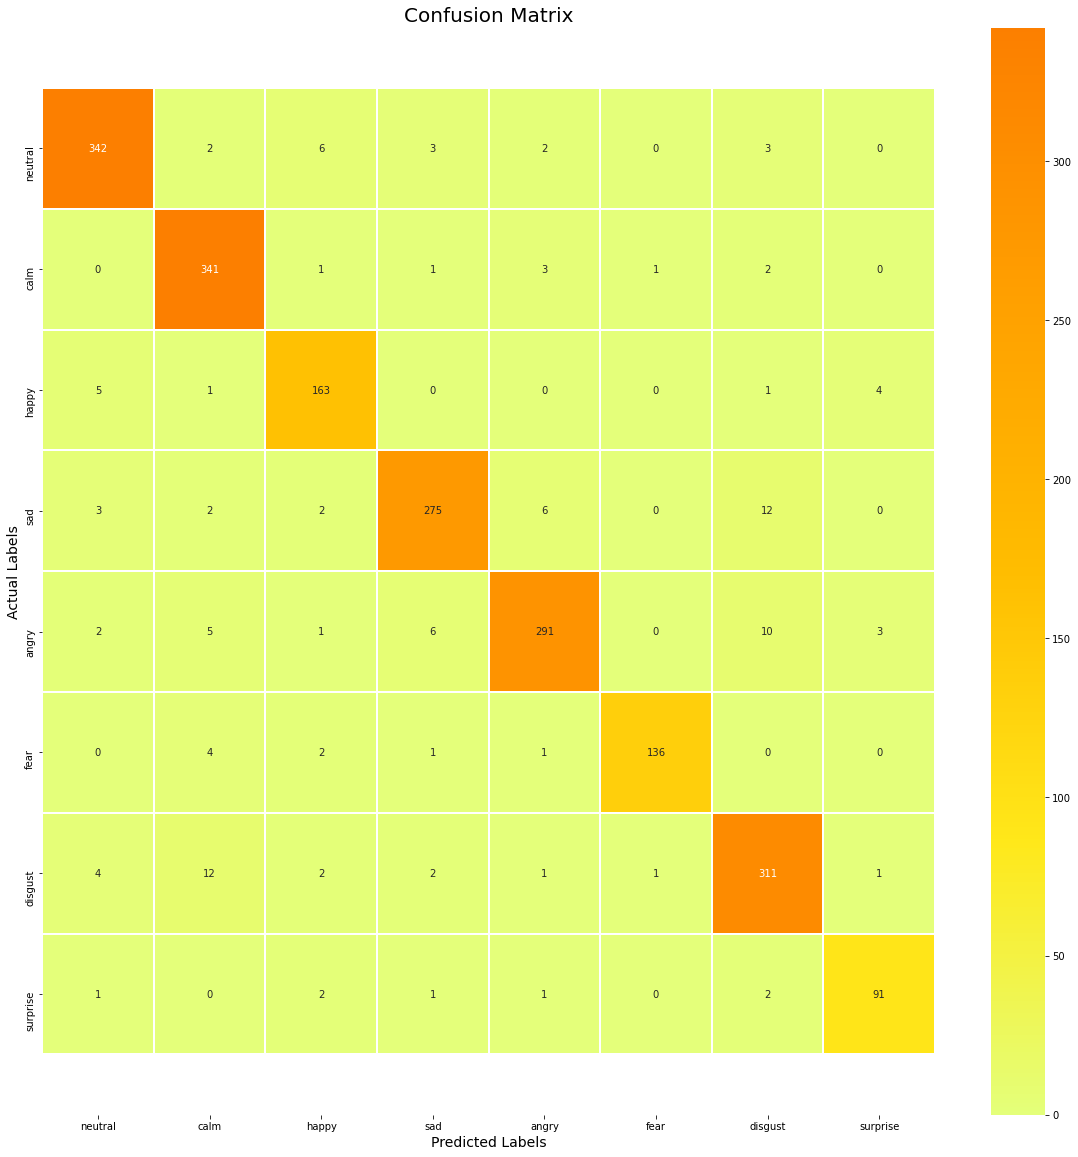

In [23]:
Y_ac1 = pd.DataFrame(Y_ac)
y_pre1 = pd.DataFrame(y_pre)
Y_ac1 = Y_ac1.replace({0:"neutral", 1:"calm", 2:"happy", 3:"sad", 4:"angry", 5:"fear", 6:"disgust", 7:"surprise"})
y_pre1 = y_pre1.replace({0:"neutral", 1:"calm", 2:"happy", 3:"sad", 4:"angry", 5:"fear", 6:"disgust", 7:"surprise"})
cm = confusion_matrix(Y_ac1, y_pre1)
plt.figure(figsize = (20, 20))
conf_matrix= pd.DataFrame(cm,index=target_names, columns=target_names)
ax = sns.heatmap(conf_matrix, linecolor='white', cmap='Wistia', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [48]:
cr=classification_report(Y_ac, y_pre)
print(classification_report(Y_ac, y_pre,digits=4, target_names=target_names))
report = classification_report(Y_ac, y_pre, digits=4, target_names=target_names, output_dict=True)
cr = pd.DataFrame(report).transpose()
cr.to_csv("result.csv", index= True)

              precision    recall  f1-score   support

     neutral     0.9855    0.9444    0.9645       144
        calm     0.9292    0.9771    0.9525       349
       happy     0.9541    0.9151    0.9342       318
         sad     0.9120    0.9311    0.9215       334
       angry     0.9580    0.9553    0.9566       358
        fear     0.9516    0.9167    0.9338       300
     disgust     0.9106    0.9368    0.9235       174
    surprise     0.9192    0.9286    0.9239        98

    accuracy                         0.9398      2075
   macro avg     0.9400    0.9381    0.9388      2075
weighted avg     0.9403    0.9398    0.9398      2075



In [49]:
print(y_pre[7])
print(Y_ac[7])
print(gender[7])

tensor(1)
tensor(1)
tensor(12)


In [50]:
male_emo=np.zeros(8,int)
female_emo=np.zeros(8,int)
male_emo_pred=np.zeros(8,int)
female_emo_pred=np.zeros(8,int)
for i in range(0,Y_ac.shape[0]):
    if (gender[i]%2)==0:
        flag1 = y_pre[i]
        female_emo_pred[flag1] = female_emo_pred[flag1] + 1
        flag2 = Y_ac[i]
        female_emo[flag2] = female_emo[flag2] + 1
    if (gender[i]%2)==1:
        flag1 = y_pre[i]
        male_emo_pred[flag1] = male_emo_pred[flag1] + 1
        flag2 = Y_ac[i]
        male_emo[flag2] = male_emo[flag2] + 1
print(male_emo)
print(female_emo)
print(male_emo_pred)
print(female_emo_pred)

[ 68 172 152 161 176 140  79  33]
[ 76 177 166 173 182 160  95  65]
[ 67 186 143 167 181 127  77  33]
[ 71 181 162 174 176 162 102  66]


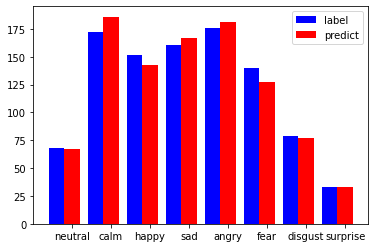

In [56]:
name_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
x =list(range(len(male_emo)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, male_emo, width=width, label='label',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, male_emo_pred, width=width, label='predict',tick_label = name_list,fc = 'r')
plt.legend()

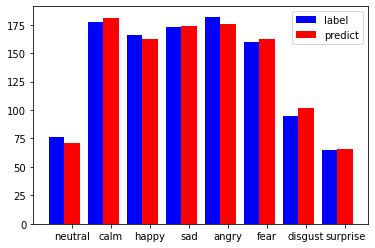

In [57]:
name_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
x =list(range(len(female_emo)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, female_emo, width=width, label='label',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, female_emo_pred, width=width, label='predict',tick_label = name_list,fc = 'r')
plt.legend()

In [25]:
from random import randint
idx=randint(0, 415-1)
print(test.iloc[idx])
im=X_test[idx]
im = im.to(device)
im= (im-mean) / std
im=im.view(1,128,259).unsqueeze(dim=1)

scores =  net(im) 
print(scores)

gender                                                            10
emotion_code                                                       7
emotion                                                      disgust
actor                                                             10
path               /Users/xx/Desktop/5452 pro/RAVDESS/03-01-07-01...
mel_spectrogram    [[-62.146507, -55.235, -47.697487, -44.032303,...
Name: 2254, dtype: object
tensor([[-0.7924, -2.4770, -0.1938,  1.3558,  2.8147,  0.9811,  2.3678,  0.9170]],
       grad_fn=<AddmmBackward0>)
